In [52]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing,neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC

There are 2 csv files in the current version of the dataset:


/kaggle/input/Mendeley_data/100_Batches_IndPenSim_V3.csv
/kaggle/input/Mendeley_data/100_Batches_IndPenSim_Statistics.csv


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [54]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [55]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [56]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: /kaggle/input/Mendeley_data/100_Batches_IndPenSim_V3.csv

In [57]:
df1 = pd.read_csv('/kaggle/input/Mendeley_data/100_Batches_IndPenSim_V3.csv', delimiter=',', nrows = 155666)

df1.dataframeName = '100_Batches_IndPenSim_V3.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 113935 rows and 2239 columns


Let's take a quick look at what the data looks like:

In [58]:
df1.head(5)
pd.DataFrame(df1.columns)
df1.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)',
       ...
       '210', '209', '208', '207', '206', '205', '204', '203', '202', '201'],
      dtype='object', length=2239)

Distribution graphs (histogram/bar graph) of sampled columns:

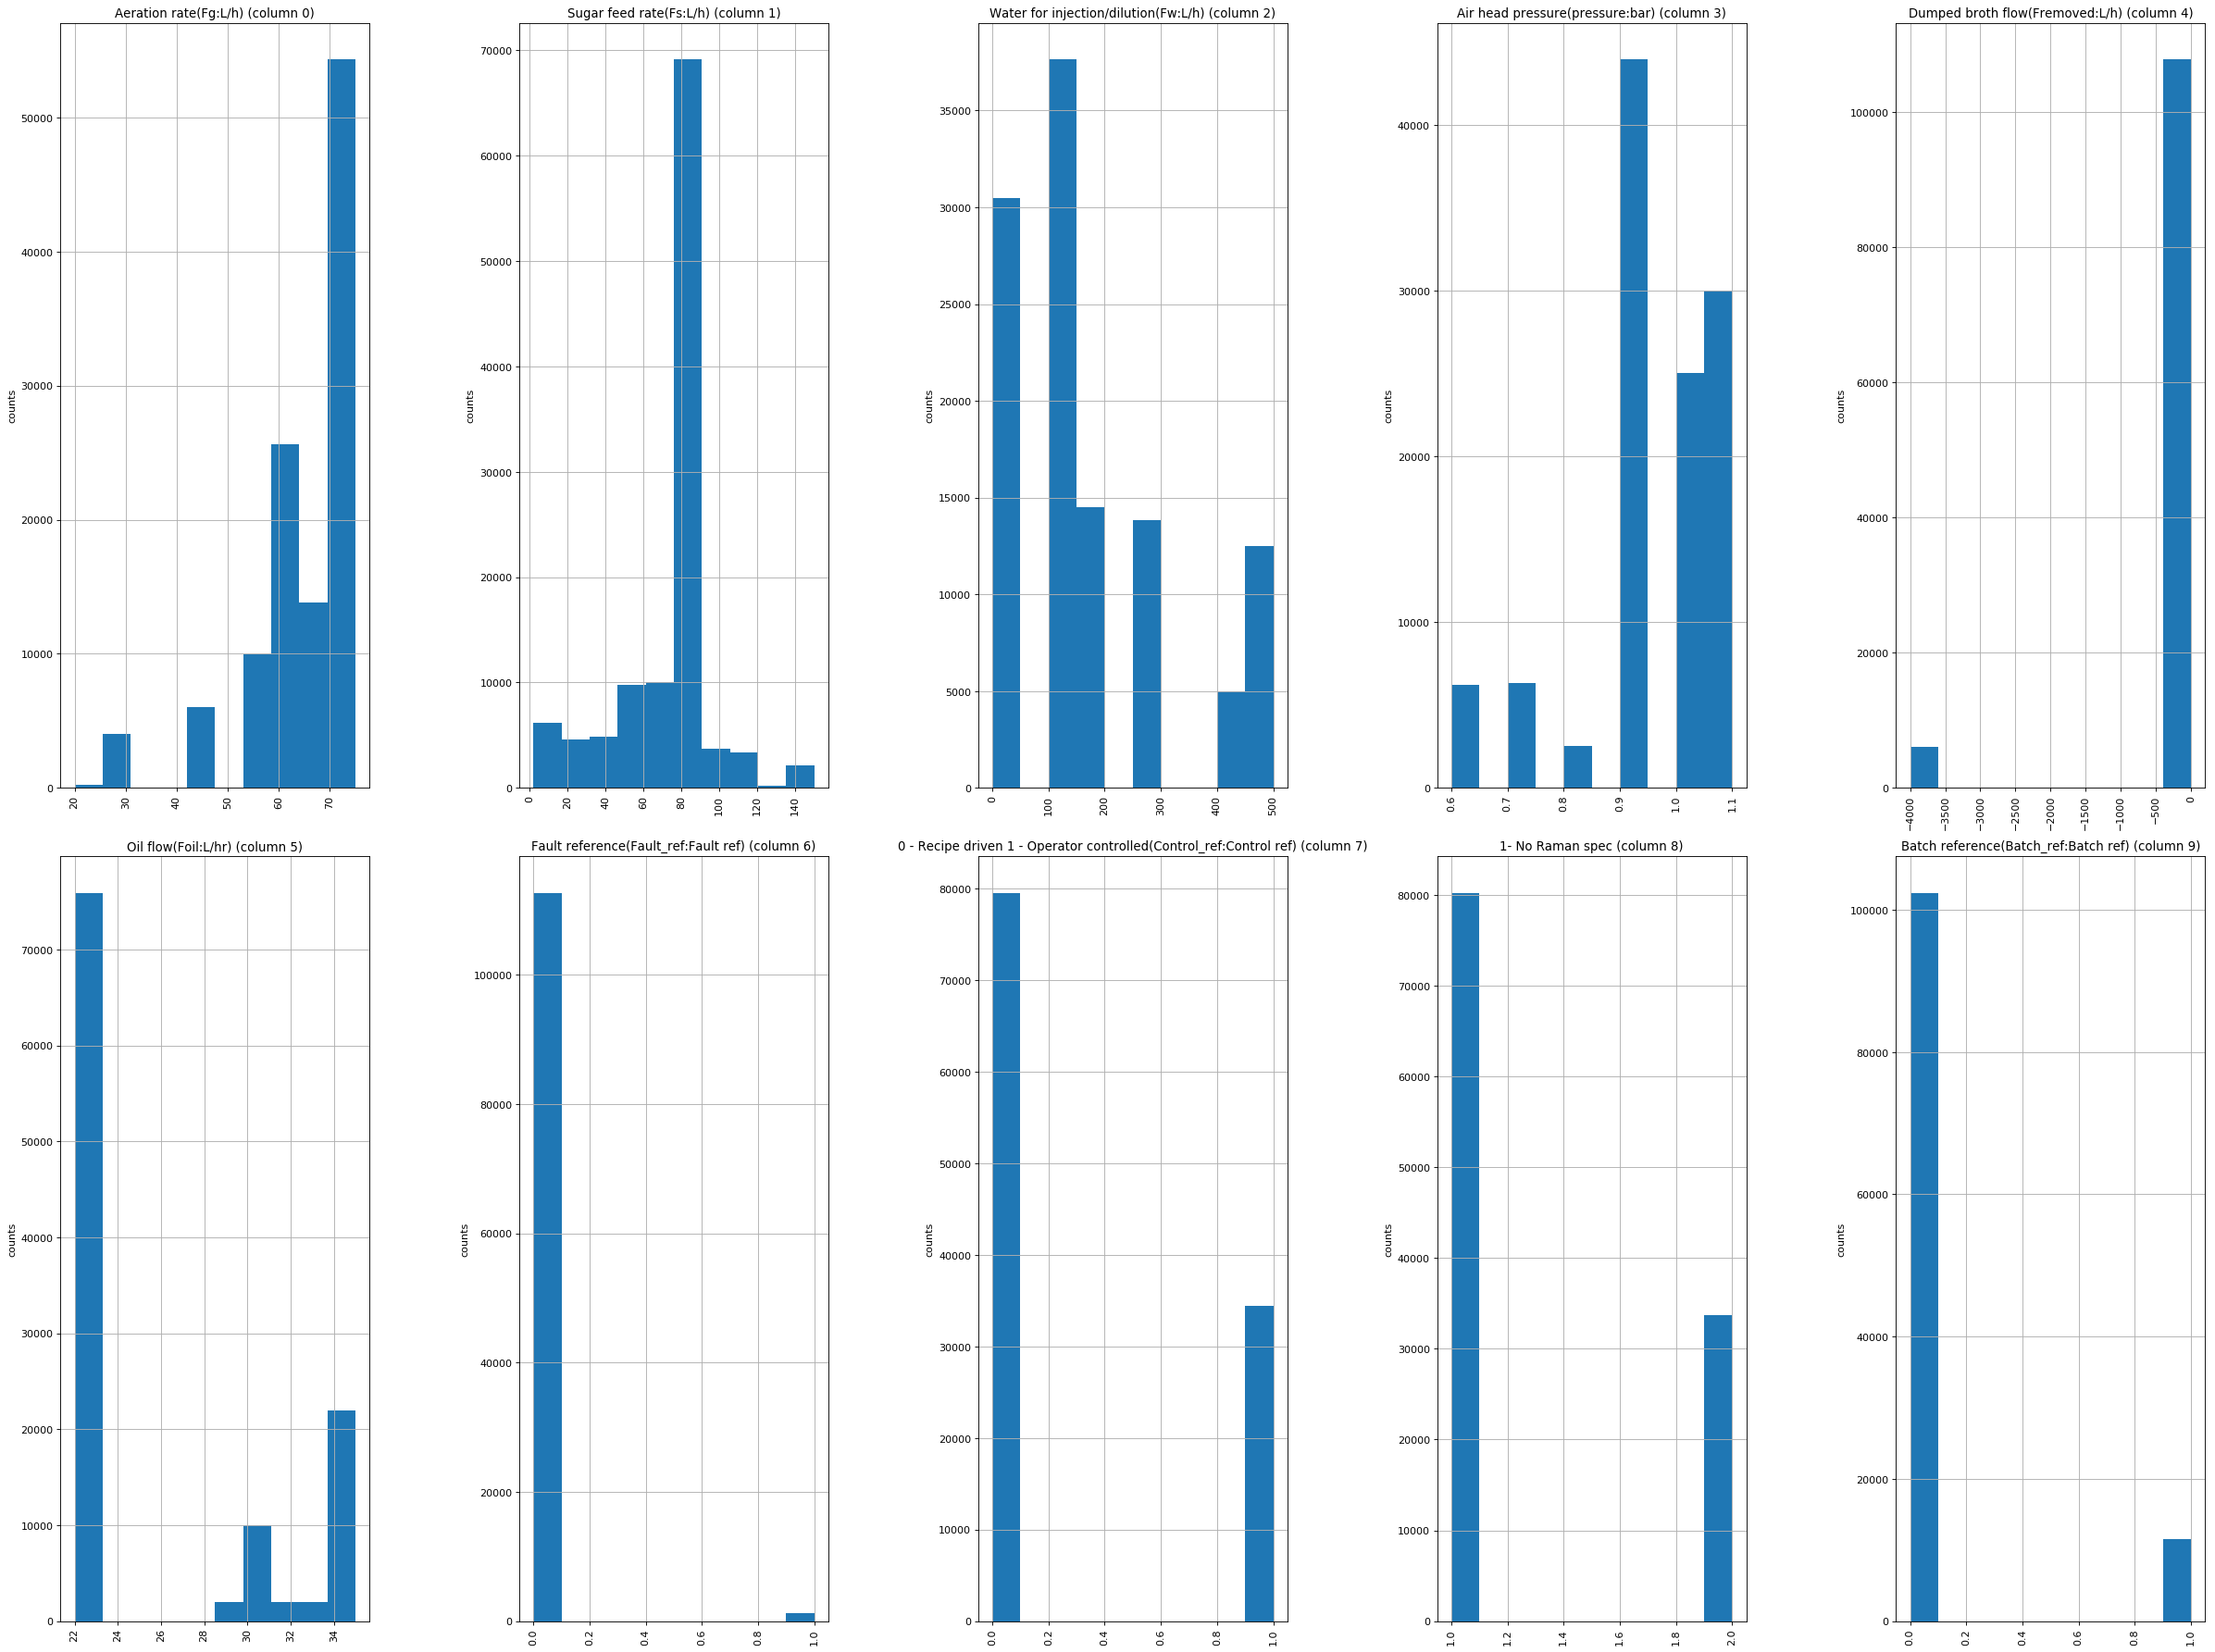

In [59]:
plotPerColumnDistribution(df1, 10, 5)

In [60]:
df2 = pd.read_csv('/kaggle/input/Mendeley_data/100_Batches_IndPenSim_Statistics.csv', delimiter=',')
df2.dataframeName = '100_Batches_IndPenSim_Statistics.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 5 columns


Let's take a quick look at what the data looks like:

In [61]:
df2.head(5)

,Batch ref,Penicllin_harvested_during_batch(kg),Penicllin_harvested_end_of_batch (kg),Penicllin_yield_total (kg),Fault ref(0-NoFault 1-Fault)
0,1,1066400.0,1720000.0,2786400.0,0
1,2,985910.0,1340100.0,2326000.0,0
2,3,1416100.0,1259200.0,2675300.0,0
3,4,815700.0,1071000.0,1886700.0,0
4,5,1128500.0,2434400.0,3562900.0,0


Distribution graphs (histogram/bar graph) of sampled columns:

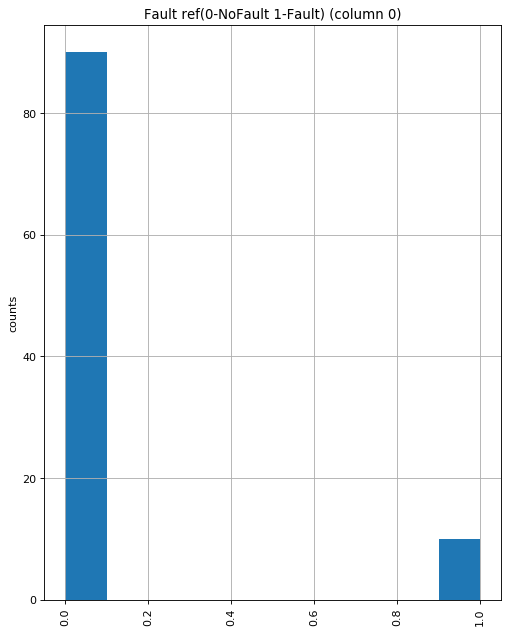

In [62]:
plotPerColumnDistribution(df2, 10, 5)

Correlation matrix:

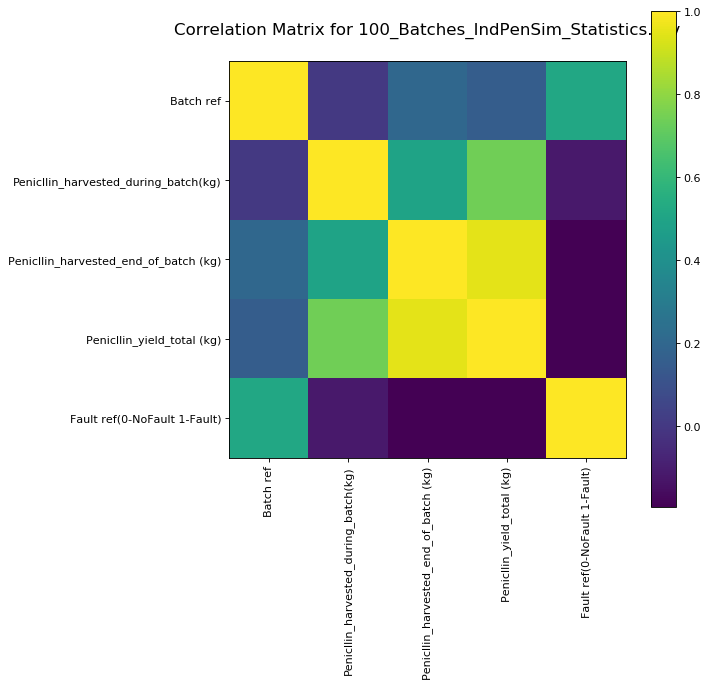

In [63]:
plotCorrelationMatrix(df2, 8)

Scatter and density plots:

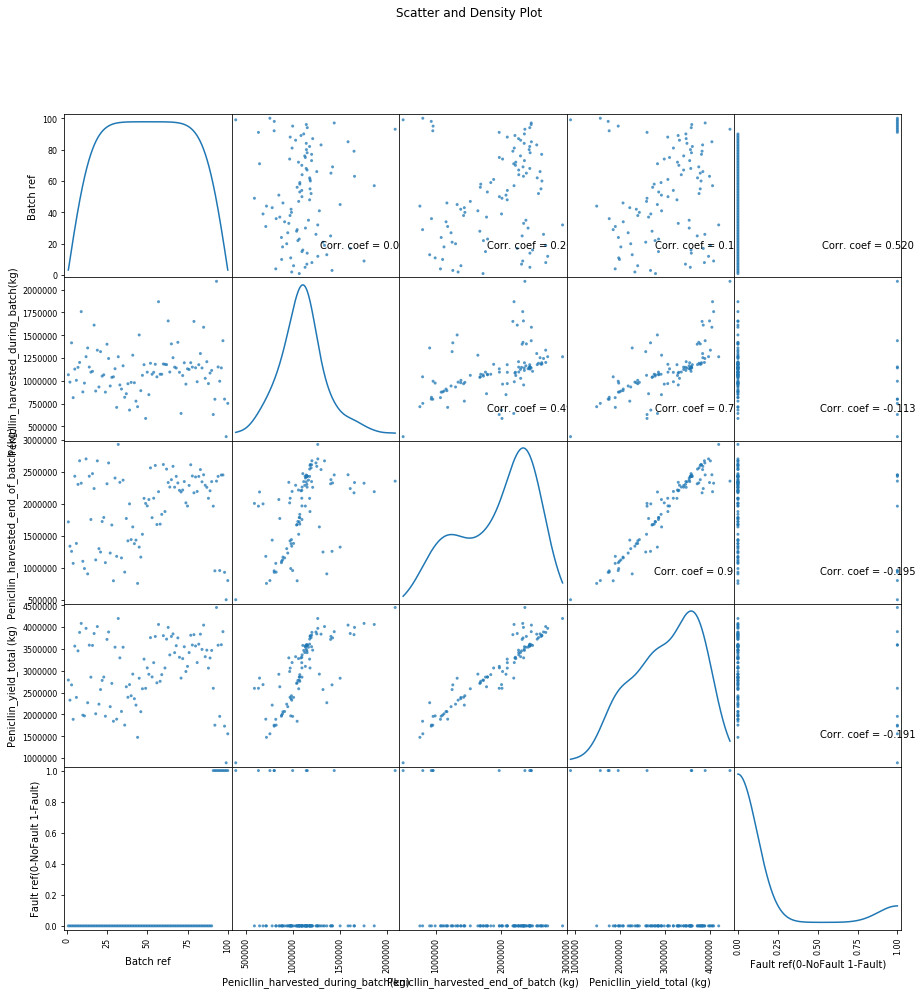

In [64]:
plotScatterMatrix(df2, 15, 10)

## Predictive Analysis 

In [65]:
df2.drop(['Batch ref'],1,inplace=True)

X=np.array(df2.drop(['Fault ref(0-NoFault 1-Fault)'],1))
y=np.array(df2['Fault ref(0-NoFault 1-Fault)'])

In [66]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
clf=neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
accurracy=clf.score(X_test, y_test)
print(f'{accurracy*100} %')

95.0 %


In [77]:
from sklearn.metrics import confusion_matrix

prediction=clf.predict(X_test)
confusion_matrix(y_test, prediction)

array([[18,  0],
       [ 2,  0]])

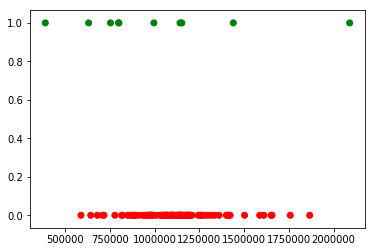

In [70]:
colormap = np.array(['r', 'g', 'b'])
x=np.array(df2['Penicllin_harvested_during_batch(kg)'],df2['Penicllin_harvested_end_of_batch (kg)'])
plt.scatter(x,df2['Fault ref(0-NoFault 1-Fault)'],c=colormap[df2['Fault ref(0-NoFault 1-Fault)']])
plt.show()

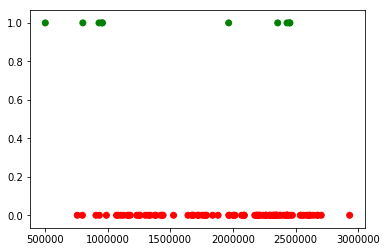

In [71]:
colormap = np.array(['r', 'g', 'b'])
plt.scatter(df2['Penicllin_harvested_end_of_batch (kg)'],df2['Fault ref(0-NoFault 1-Fault)'],c=colormap[df2['Fault ref(0-NoFault 1-Fault)']])
plt.show()


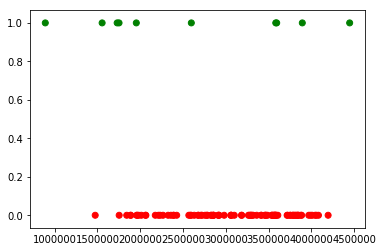

In [72]:
colormap = np.array(['r', 'g', 'b'])
plt.scatter(df2['Penicllin_yield_total (kg)'],df2['Fault ref(0-NoFault 1-Fault)'],c=colormap[df2['Fault ref(0-NoFault 1-Fault)']])
plt.show()

In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       0.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20

